In [18]:
#Import the libraries 

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
#data can be found here: 
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py

#SOLUTION IS BASED ON THE REFERENCE: https://www.tensorflow.org/tutorials/images/transfer_learning#evaluation_and_prediction

Found 245 files belonging to 2 classes.
Found 153 files belonging to 2 classes.


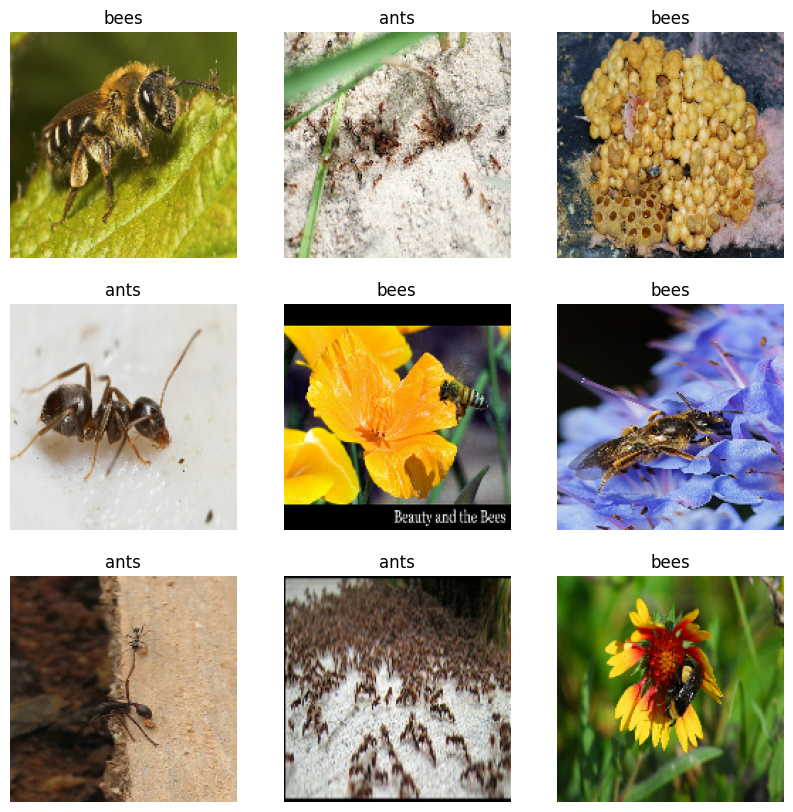

In [19]:
#DATA PREPROCESSING

train_dir= '/Users/Admin/Downloads/hymenoptera_data/train'
validation_dir= '/Users/Admin/Downloads/hymenoptera_data/val'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Number of validation batches: 4
Number of test batches: 1


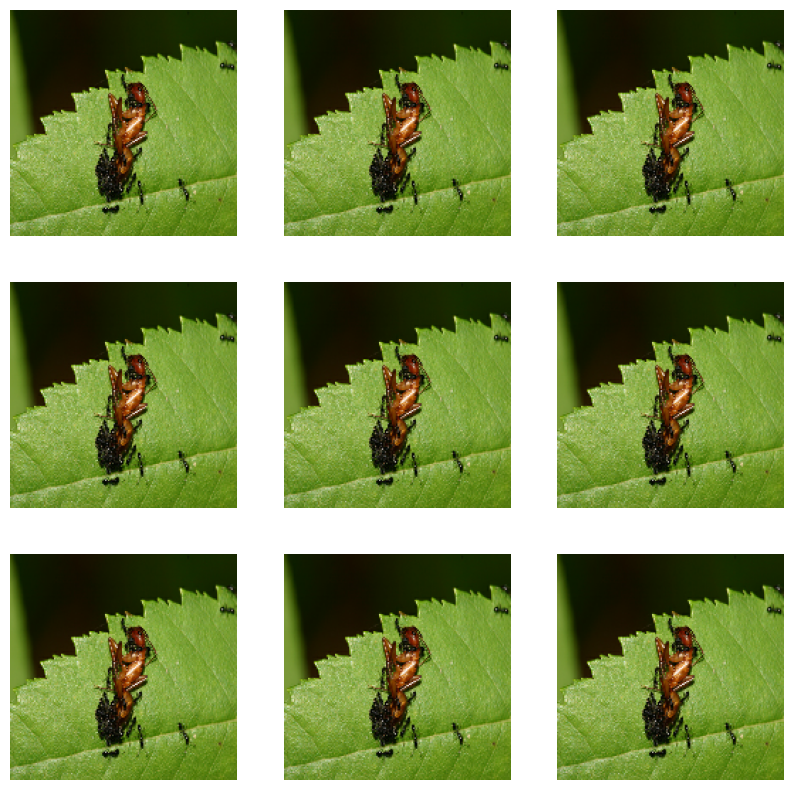

In [20]:
# DATASET CONFIGURATION AND 

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
#%%
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
#%%

In [21]:
#INITIALIZATION OF THE MODEL AND CLASSIFICATION HEAD

# Model creation based on the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
#%%
base_model.trainable = False
# Model architecture
base_model.summary()

#%%
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
#%%
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5, 5, 1280)
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0        

In [22]:
#BUILDING AND COMPILING THE MODEL  

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#%%
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()
len(model.trainable_variables)
#%%
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
#%%

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

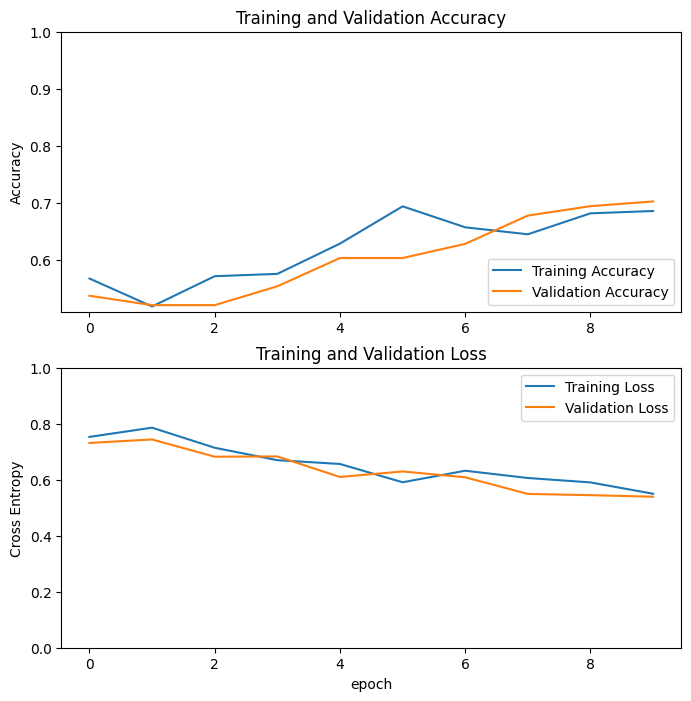

In [23]:
#LEARNING CURVES 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
#FINE TUNING 

base_model.trainable = True
# Display how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the command`fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
  #%%
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)
#%%
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

Number of layers in the base model:  154
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                  

Epoch 10/20
8/8 [==============================] - 31s 2s/step - loss: 0.4242 - accuracy: 0.8000 - val_loss: 0.3428 - val_accuracy: 0.8347
Epoch 11/20
8/8 [==============================] - 14s 2s/step - loss: 0.2635 - accuracy: 0.8980 - val_loss: 0.2759 - val_accuracy: 0.8843
Epoch 12/20
8/8 [==============================] - 13s 2s/step - loss: 0.2198 - accuracy: 0.9224 - val_loss: 0.2634 - val_accuracy: 0.8926
Epoch 13/20
8/8 [==============================] - 15s 2s/step - loss: 0.1916 - accuracy: 0.9265 - val_loss: 0.2223 - val_accuracy: 0.9091
Epoch 14/20
8/8 [==============================] - 16s 2s/step - loss: 0.1620 - accuracy: 0.9469 - val_loss: 0.1852 - val_accuracy: 0.9174
Epoch 15/20
8/8 [==============================] - 15s 2s/step - loss: 0.1331 - accuracy: 0.9673 - val_loss: 0.2322 - val_accuracy: 0.9091
Epoch 16/20
8/8 [==============================] - 13s 2s/step - loss: 0.1274 - accuracy: 0.9592 - val_loss: 0.2096 - val_accuracy: 0.9256
Epoch 17/20
8/8 [==========

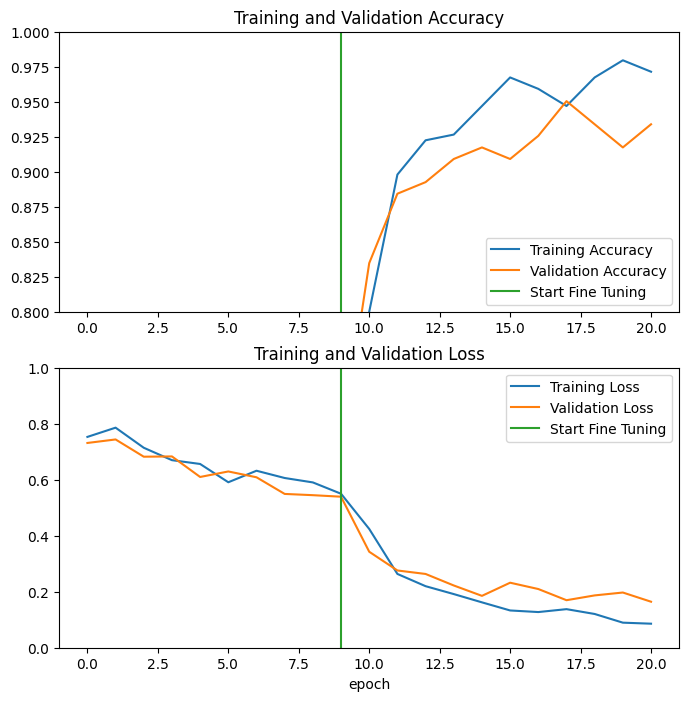

1/1 [==============================] - 1s 1s/step - loss: 0.3440 - accuracy: 0.8438
Test accuracy : 0.84375


In [25]:
#%% PLOTS, FINE TUNING


history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

Predictions:
 [0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1 0]
Labels:
 [1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1 0]


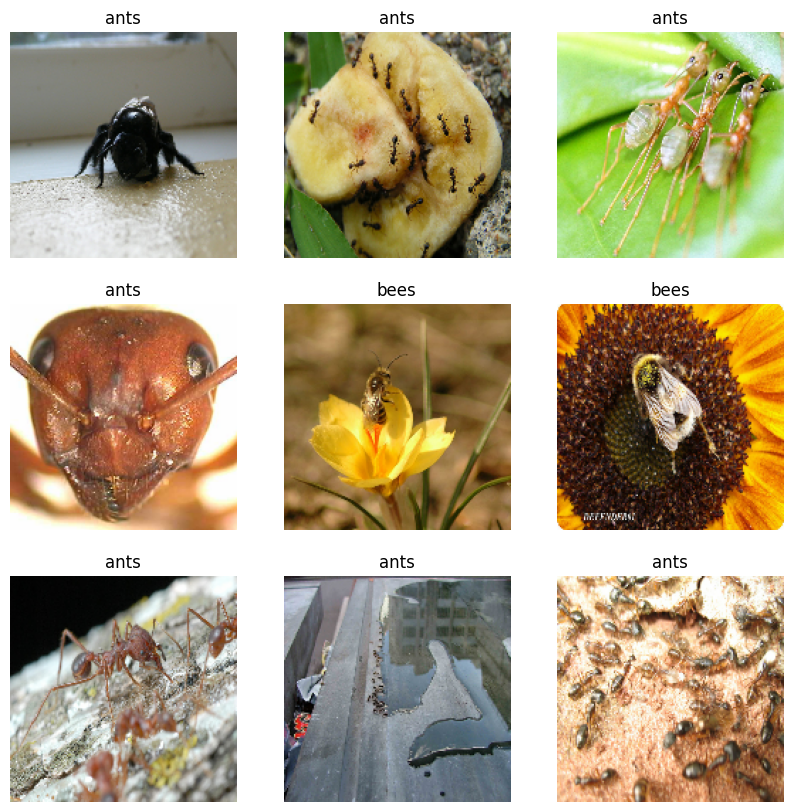

In [26]:
#EVALUATION AND PREDICTION

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

              precision    recall  f1-score   support

     class 0       0.94      1.00      0.97        16
     class 1       1.00      0.94      0.97        16

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



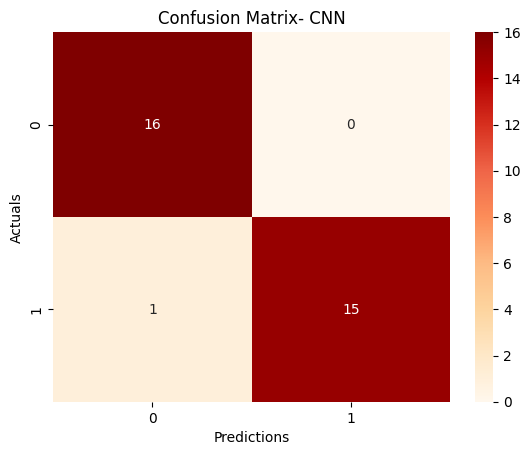

In [27]:
# FINAL RESULTS, USING CONFUSION MATRIX AND PERFORMANCE METRICS

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

y_true = label_batch
y_pred = predictions.numpy()

conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
cm= metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="OrRd");  
# labels, title and ticks
ax.set_xlabel('Predictions');ax.set_ylabel('Actuals'); 
ax.set_title('Confusion Matrix- CNN'); 

#%%
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names))
